# HAND Final Project

This is the final project for my Terrain Analysis and Hydrologic Modelling course held in Autumn semester of 2024. The main goal for this was to apply Height Above Nearest Drainage (HAND) to something.

## Table of contents

1. [Import modules](#import-modules)
2. [Meet the DEM](#meet-the-dem)
3. [Find out the flow direction](#find-out-the-flow-direction)

## Import modules

In [1]:
import matplotlib, matplotlib.colors as colors, matplotlib.font_manager as font_manager, matplotlib.patches as patches, matplotlib.pyplot as plt
import numpy as np
import pyflwdir
import rasterio, rasterio.crs as crs, rasterio.features as features
import shapely.geometry as geometry

### Helper functions

In [2]:
# Load Noto Sans Traditional Chinese, a Chinese font made by Google. Link: https://fonts.google.com/noto/specimen/Noto+Sans+TC
font_path = 'C:\Windows\\Fonts\\NotoSansTC-Regular.otf'
font_manager.fontManager.addfont(font_path)
matplotlib.rcParams.update({
    'font.sans-serif': font_manager.FontProperties(fname = font_path).get_name(),
})

del font_path

# Helper function to show 2D terrain
def show_terrain_2D(x: np.ndarray,
                    cmap: str = 'terrain_2',
                    title: str = 'DEM',
                    colorbar_label: str = 'Elevation (m)',
                    xlabel: str = 'X',
                    ylabel: str = 'Y',
                    size: tuple = (12, 8),
                    extent: tuple = False,
                    extent_scale: float = 1,
                    contour: bool = False,
                    contour_color: str = 'grey',
                    colorbar_fraction: float = 0.045,
                    colorbar_pad: float = 0.05,
                    equal_scale: bool = False,
                    invert_y_axis: bool = True,
                    norm: bool = None,
                    two_slope: bool = False,
                    cont: bool = False,
                    tight_layout: bool = True,
                    show_fig: bool = True,
                    save_fig: str = None):

    if cmap == 'terrain_2':
        cmap = colors.LinearSegmentedColormap.from_list('terrain_2', ['#F5FCF1', '#A2D18C', '#608A4F'])

    fig, ax = plt.subplots()
    fig.set_size_inches(size)
    if two_slope:
        im = ax.imshow(x[::-1] if invert_y_axis else x,
                   cmap = cmap,
                   extent =  tuple(np.array(extent) * extent_scale) if extent else None,
                   norm = colors.TwoSlopeNorm(vcenter = 0))
    else:
        im = ax.imshow(x[::-1] if invert_y_axis else x,
                       extent = tuple(np.array(extent) * extent_scale) if extent else None,
                       cmap = cmap,
                       norm = norm)
    if contour:
        x_range = ((extent[1] - extent[0]) / x.shape[1] * np.arange(x.shape[1]) + extent[0]) if extent else np.arange(x.shape[1])
        y_range = ((extent[3] - extent[2]) / x.shape[0] * np.arange(x.shape[0]) + extent[2]) if extent else np.arange(x.shape[0])
        x_coord, y_coord = np.meshgrid(x_range * extent_scale, y_range * extent_scale)
        ax.contour(x_coord, y_coord, x if invert_y_axis else x[::-1], colors = contour_color, linewidths = 1)
    cb = fig.colorbar(im, ax = ax, fraction = colorbar_fraction, pad = colorbar_pad)
    cb.set_label(colorbar_label)
    ax.set(title = title, xlabel = xlabel, ylabel = ylabel)
    if equal_scale:
        ax.set_aspect('equal', adjustable = 'box')
    if invert_y_axis:
        ax.invert_yaxis()
    if tight_layout:
        plt.tight_layout()

    if not cont:
        if save_fig:
            plt.savefig(save_fig)

        if show_fig:
            plt.show()

        plt.close()

# Helper function to snap streams to the grid
def snap_streams_to_grid(streams: list[np.ndarray], reference_shape: np.ndarray, extent: tuple, scale: float):
    output = np.zeros(reference_shape)
    x_range = ((extent[1] - extent[0]) / reference_shape[1] * np.arange(reference_shape[1]) + extent[0]) if extent else np.arange(reference_shape[1])
    y_range = ((extent[3] - extent[2]) / reference_shape[0] * np.arange(reference_shape[0]) + extent[2]) if extent else np.arange(reference_shape[0])
    y_range = y_range[::-1]

    for stream in streams:
        stream_x = stream[0] / scale
        stream_y = stream[1] / scale

        for i in range(len(stream_x) - 1):
            x_start, y_start = stream_x[i]    , stream_y[i]
            x_end,   y_end   = stream_x[i + 1], stream_y[i + 1]
            num_points = int(np.hypot(x_end - x_start, y_end - y_start) / 20) + 1

            for point_x, point_y in zip(np.linspace(x_start, x_end, num_points),
                                        np.linspace(y_start, y_end, num_points)):
                output[
                    np.abs(y_range - point_y).argmin(),
                    np.abs(x_range - point_x).argmin()
                ] = 1

    return output

## Meet the DEM

The DEM was extracted from the 20-meter DEM provided by Ministry of Interior of Taiwan, covering the catachment of *Dingzilan River* (Chinese: 丁子蘭溪) in Shuangxi District, New Taipei City.

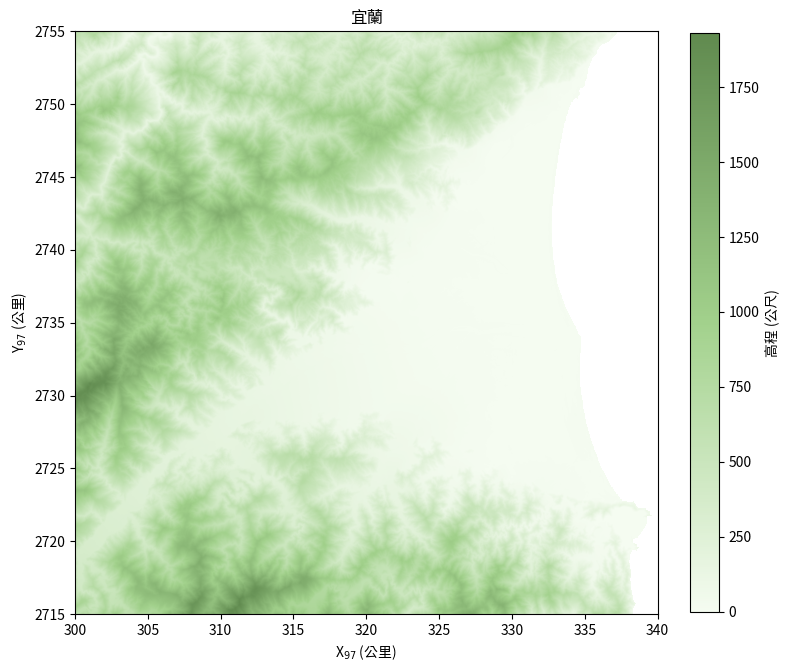

In [3]:
# Variable definition
source_elevation : np.ndarray
source_extent    : tuple
source_projection: crs.CRS
source_scale     : float = 1e-3
source_transform : rasterio.Affine

# Reading the file
with rasterio.open(r'src\Yilan.tif') as f:
    source_elevation  = f.read(1).astype(float)
    source_extent     = (f.bounds.left, f.bounds.right, f.bounds.bottom, f.bounds.top)
    source_projection = f.crs
    source_transform  = f.transform

del f

# Variable assertion
assert isinstance(source_elevation, np.ndarray)
assert isinstance(source_extent, tuple)
assert isinstance(source_projection, crs.CRS)
assert isinstance(source_transform, rasterio.Affine)

# Remove (assign) NaNs
source_elevation[source_elevation < -100] = np.nan

# Show terrain as image
show_terrain_2D(source_elevation,
                title = '宜蘭',
                colorbar_label = '高程 (公尺)',
                xlabel = 'X$_{97}$ (公里)',
                ylabel = 'Y$_{97}$ (公里)',
                size = (8, 8),
                extent = source_extent,
                extent_scale = source_scale,
                invert_y_axis = False,
                save_fig = 'plot\\DEM.png')

## Find out the flow direction

The following operations requires [PyFlwDir](https://deltares.github.io/pyflwdir/latest/index.html) module to complete. In order to claculate the HAND value, the module has to retrieve the flow direction of the DEM.

In [4]:
# Variable definition
flow_direction    : pyflwdir.FlwdirRaster
local_flow        : np.ndarray
modified_elevation: np.ndarray

# Fill depressions & find the local flow direction
modified_elevation, local_flow = pyflwdir.dem.fill_depressions(
    source_elevation,
    nodata = np.nan
)

assert isinstance(local_flow, np.ndarray)
assert isinstance(modified_elevation, np.ndarray)

# Create FlwdirRaster object
flow_direction_py = pyflwdir.from_array(
    local_flow,
    ftype = 'd8',
    mask = np.where(modified_elevation != np.nan, True, False),
    transform = source_transform,
    latlon = source_projection.to_epsg() == 4326,
    cache = True
)

### Or ArcGIS's might be better....

In [5]:
with rasterio.open(r'src\Yilan_Flow_Dir.tif') as g:
    source_direction  = g.read(1)
del g

with rasterio.open(r'src\Yilan_Filled.tif') as h:
    modified_elevation = h.read(1)
    modified_elevation[modified_elevation == -32767] = np.nan
del h

flow_direction = pyflwdir.from_array(
    source_direction,
    ftype = 'd8',
    mask = np.where(modified_elevation != np.nan, True, False),
    transform = source_transform,
    latlon = source_projection.to_epsg() == 4326,
    cache = True
)

### Streams & Basins

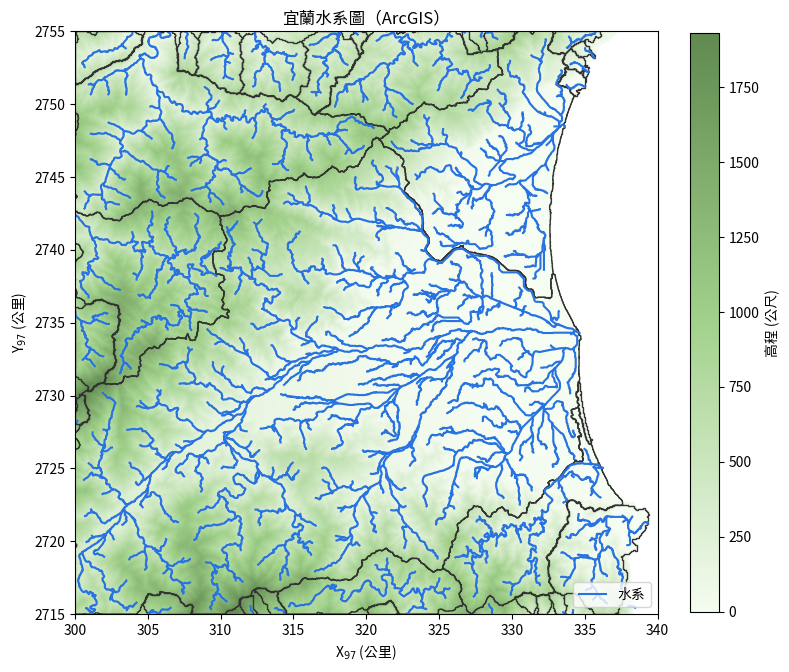

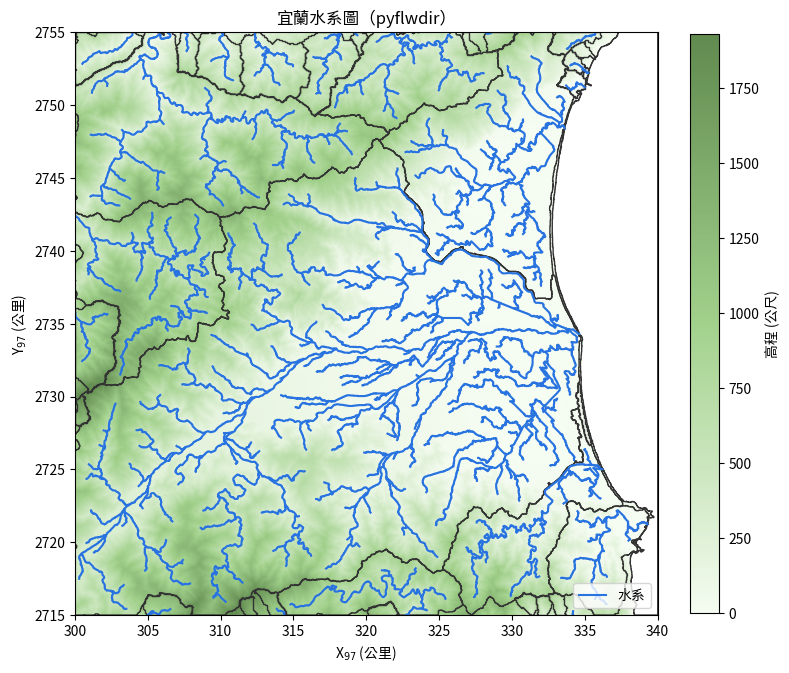

In [6]:
def show_stream_basins(fwr: pyflwdir.FlwdirRaster, name: str):
    # Retrieve streams
    streams_coordinates = [
        np.array(
            stream['geometry']['coordinates']
        ).T * source_scale
        for stream
        in fwr.streams(
            min_sto = 6
        )
    ]

    # Retrieve basins
    basins = fwr.basins()
    basin_boundaries = [
        np.array(basin[0]['coordinates'][0]) * source_scale
        for basin
        in list(
            features.shapes(
                basins.astype(rasterio.float32),
                connectivity = 8,
                transform = source_transform
            )
        )
        if geometry.shape(basin[0]).area > 1e6
    ]

    # Show streams & basin
    show_terrain_2D(modified_elevation,
                    title = f'宜蘭水系圖（{name}）',
                    colorbar_label = '高程 (公尺)',
                    xlabel = 'X$_{97}$ (公里)',
                    ylabel = 'Y$_{97}$ (公里)',
                    size = (8, 8),
                    equal_scale = True,
                    extent = source_extent,
                    extent_scale = source_scale,
                    invert_y_axis = False,
                    cont = True)

    for idx, stream in enumerate(streams_coordinates):
        plt.gca().plot(stream[0], stream[1], color = '#2873E0', label = '水系' if idx == 0 else None)
    for basin in basin_boundaries:
        plt.gca().add_patch(
            patches.Polygon(
                basin,
                edgecolor = '#333',
                facecolor = '#FFFFFF00'
            )
        )

    plt.gca().legend(loc = 4)
    plt.savefig(f'plot\\Basin_{name}.png')
    plt.show()

show_stream_basins(flow_direction, 'ArcGIS')
show_stream_basins(flow_direction_py, 'pyflwdir')

## Derive the HAND value

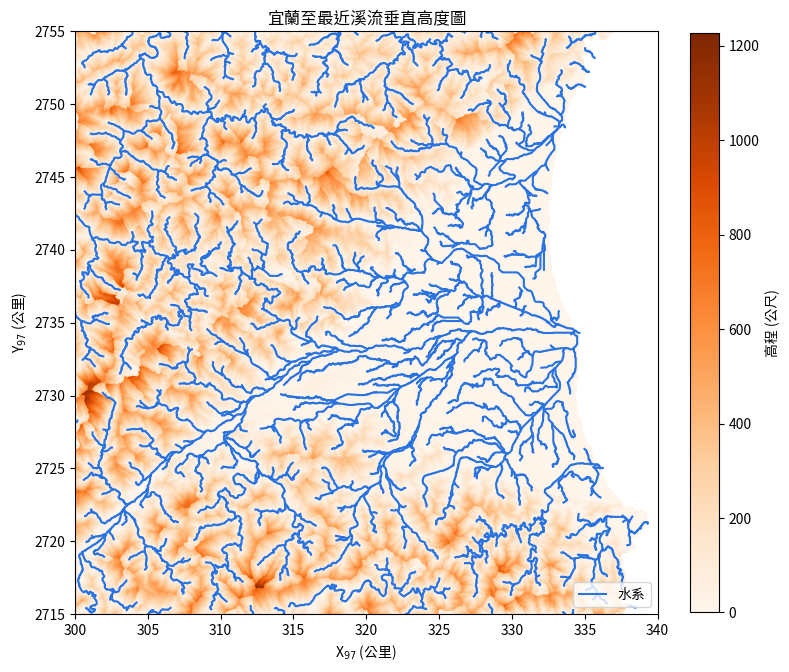

In [7]:
# Derive the hand value
hand_value = flow_direction.hand(
    flow_direction.stream_order() >= 6,
    modified_elevation
)

streams_coordinates = [
    np.array(
        stream['geometry']['coordinates']
    ).T * source_scale
    for stream
    in flow_direction.streams(
        min_sto = 6
    )
]

# Show the HAND value
show_terrain_2D(hand_value,
                cmap = 'Oranges',
                title = '宜蘭至最近溪流垂直高度圖',
                colorbar_label = '高程 (公尺)',
                xlabel = 'X$_{97}$ (公里)',
                ylabel = 'Y$_{97}$ (公里)',
                size = (8, 8),
                extent = source_extent,
                extent_scale = source_scale,
                invert_y_axis = False,
                cont = True)
for idx, stream in enumerate(streams_coordinates):
    plt.gca().plot(stream[0], stream[1], color = '#2873E0', label = '水系' if idx == 0 else None)
plt.gca().legend(loc = 4)
plt.savefig('plot\\HAND.png')
plt.show()

## Terrain Indices

### Horizontal distance to the nearest drainage (HDTND)

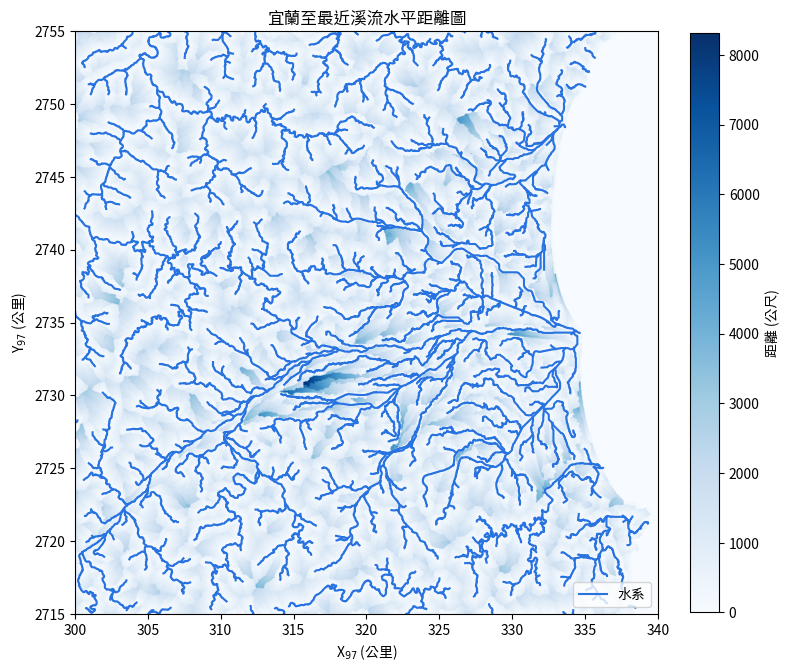

In [8]:
# Find out the horizontal distance to the nearest drainage (distance to the nearest drainage, D2D)
_index, distance = flow_direction.snap(
    xy = flow_direction.xy(np.arange(np.prod(source_elevation.shape))),
    mask = flow_direction.stream_order() >= 6,
    unit = 'm'
)
d2d_value = distance.reshape(source_elevation.shape)

# Show the HDTND / D2D value
show_terrain_2D(d2d_value,
                cmap = 'Blues',
                title = '宜蘭至最近溪流水平距離圖',
                colorbar_label = '距離 (公尺)',
                xlabel = 'X$_{97}$ (公里)',
                ylabel = 'Y$_{97}$ (公里)',
                size = (8, 8),
                extent = source_extent,
                extent_scale = source_scale,
                invert_y_axis = False,
                cont = True)
for idx, stream in enumerate(streams_coordinates):
    plt.gca().plot(stream[0], stream[1], color = '#2873E0', label = '水系' if idx == 0 else None)
plt.gca().legend(loc = 4)
plt.savefig('plot\\D2D.png')
plt.show()

### Local slope

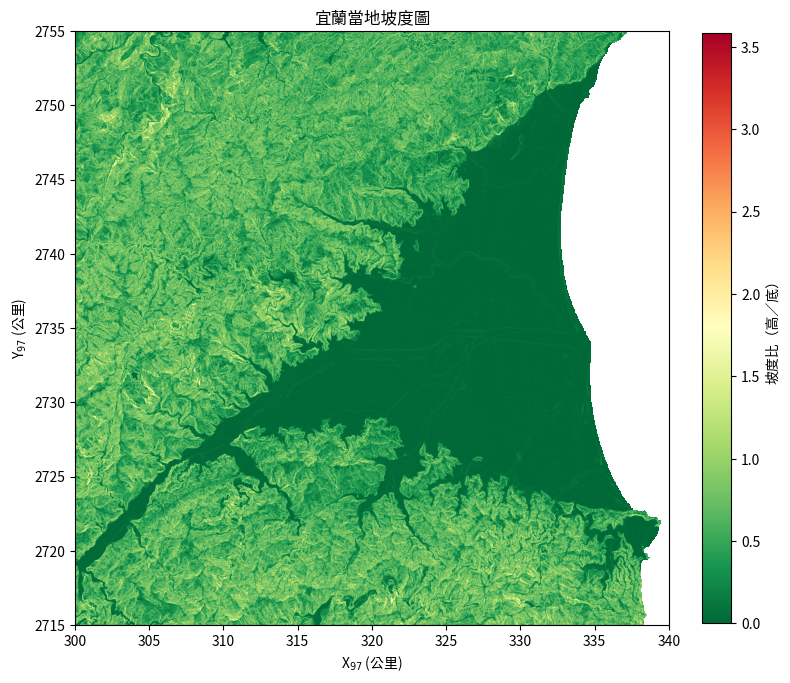

In [9]:
slope_value = pyflwdir.dem.slope(modified_elevation,
                                 transform = source_transform)

show_terrain_2D(slope_value,
                cmap = 'RdYlGn_r',
                title = '宜蘭當地坡度圖',
                colorbar_label = '坡度比（高／底）',
                xlabel = 'X$_{97}$ (公里)',
                ylabel = 'Y$_{97}$ (公里)',
                size = (8, 8),
                extent = source_extent,
                extent_scale = source_scale,
                invert_y_axis = False,
                save_fig = 'plot\\slope.png')

## A way to examine the landscape?

In [28]:
# Keep big & medium basins (> 10 square kilometers, roughly using bbox) in the region
basin_mask = flow_direction.basins()
basin_masks = []
basin_ids, bbox_array, global_bbox = flow_direction.basin_bounds()
for id, bbox in zip(basin_ids, bbox_array):
    minx, miny, maxx, maxy = bbox
    bbox_geometry = geometry.box(minx, miny, maxx, maxy)
    if bbox_geometry.area > 1e7:
        curr_mask = (basin_mask == id)
        basin_masks.append(curr_mask)

len(basin_masks)    # 13

13

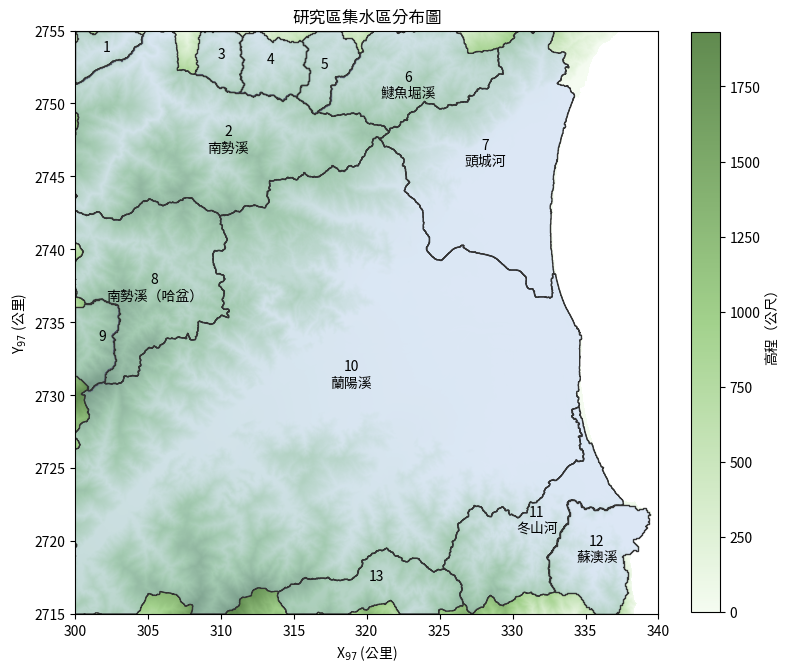

In [84]:
# Show filtered basins
filtered_basins = np.zeros(modified_elevation.shape)
for idx, basin_set in enumerate(basin_masks):
    filtered_basins[basin_set] = idx + 1

filtered_basin_boundaries = [
    np.array(basin[0]['coordinates'][0]) * source_scale
    for basin
    in list(
        features.shapes(
            filtered_basins.astype(rasterio.float32),
            connectivity = 8,
            transform = source_transform
        )
    )
    if geometry.shape(basin[0]).area > 1e6
]

# The order and number of the basins are different, you have to manually assign them back to original indices.
# I have examined the relationship between new and old indices.
filtered_ordered_basin_boundaries = [
    (filtered_basin_boundaries[4], ''),
    (filtered_basin_boundaries[9], '南勢溪'),
    (filtered_basin_boundaries[5], ''),
    (filtered_basin_boundaries[6], ''),
    (filtered_basin_boundaries[7], ''),
    (filtered_basin_boundaries[8], '𩻸魚堀溪'),
    (filtered_basin_boundaries[10], '頭城河'),
    (filtered_basin_boundaries[11], '南勢溪（哈盆）'),
    (filtered_basin_boundaries[12], ''),
    (filtered_basin_boundaries[14], '蘭陽溪'),
    (filtered_basin_boundaries[17], '冬山河'),
    (filtered_basin_boundaries[15], '蘇澳溪'),
    (filtered_basin_boundaries[16], ''),
]

show_terrain_2D(modified_elevation,
                title = '研究區集水區分布圖',
                colorbar_label = '高程（公尺）',
                xlabel = 'X$_{97}$ (公里)',
                ylabel = 'Y$_{97}$ (公里)',
                size = (8, 8),
                extent = source_extent,
                extent_scale = source_scale,
                invert_y_axis = False,
                cont = True)

for idx, (basin, name) in enumerate(filtered_ordered_basin_boundaries):
    plt.gca().add_patch(
        patches.Polygon(
            basin,
            edgecolor = '#333',
            facecolor = '#AABFFF55'
        )
    )
    plt.gca().text(basin.mean(axis = 0)[0],
                   basin.mean(axis = 0)[1],
                   f'{idx + 1}\n{name}',
                   fontsize = 10,
                   ha = 'center',
                   va = 'center')

plt.show()

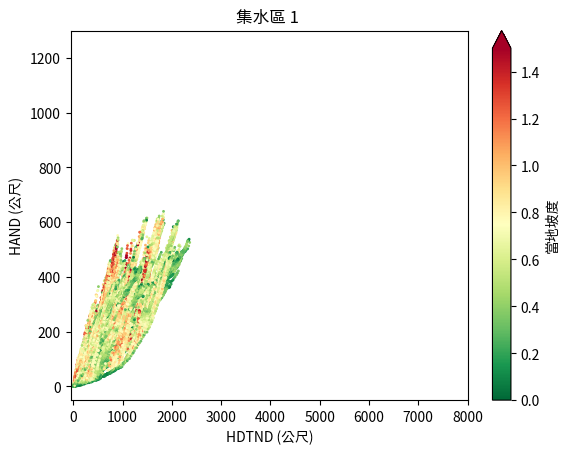

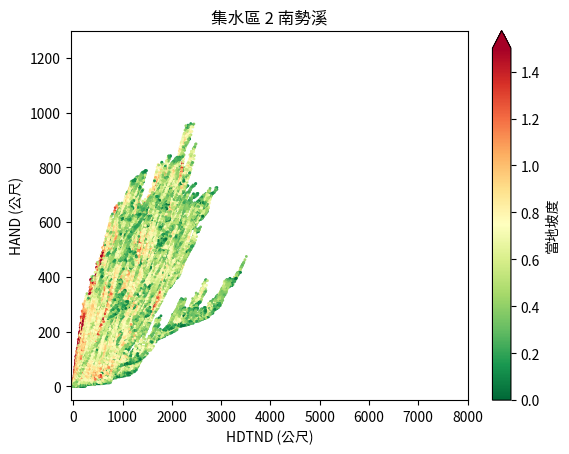

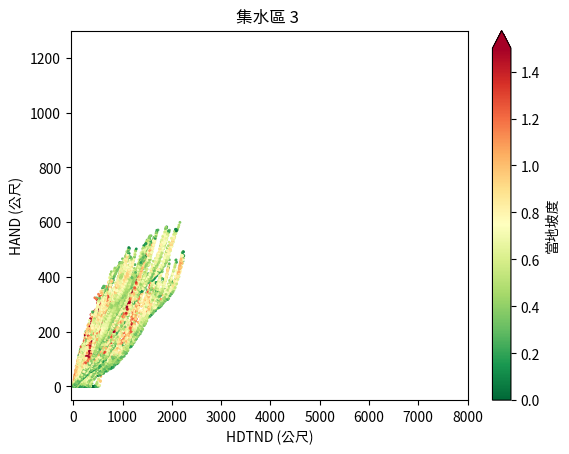

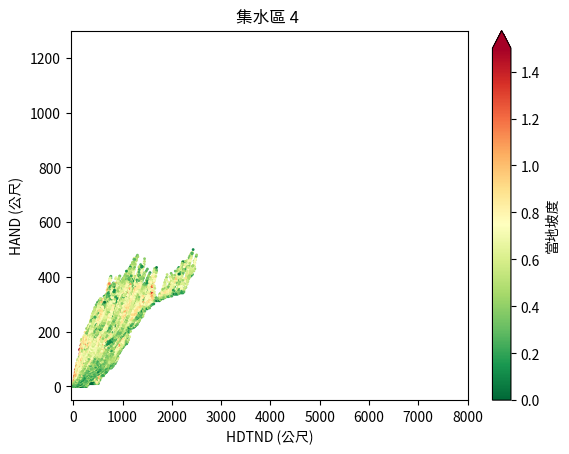

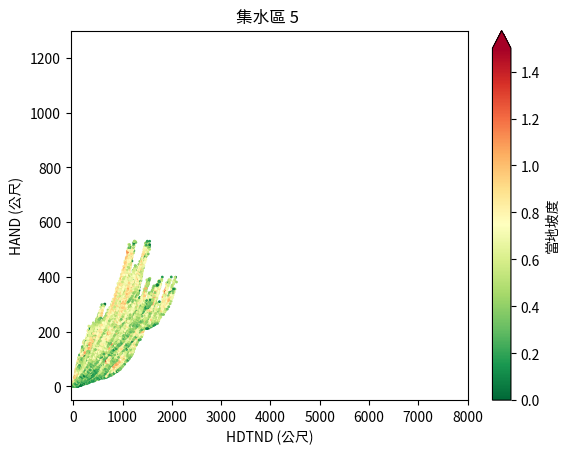

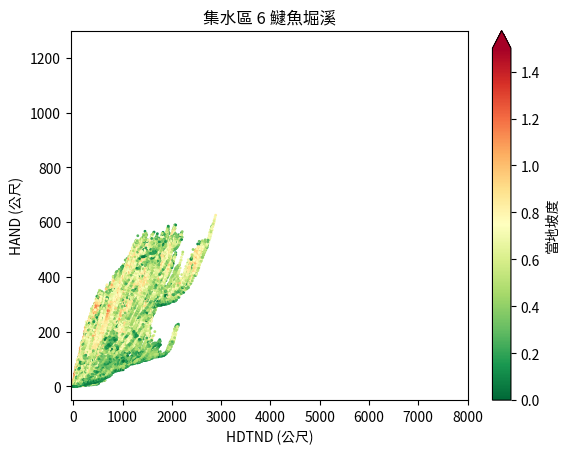

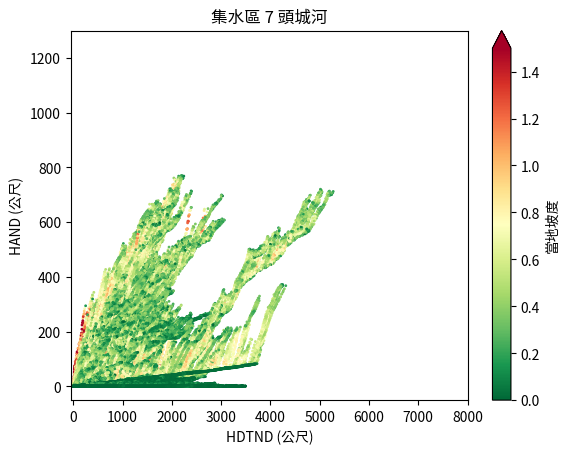

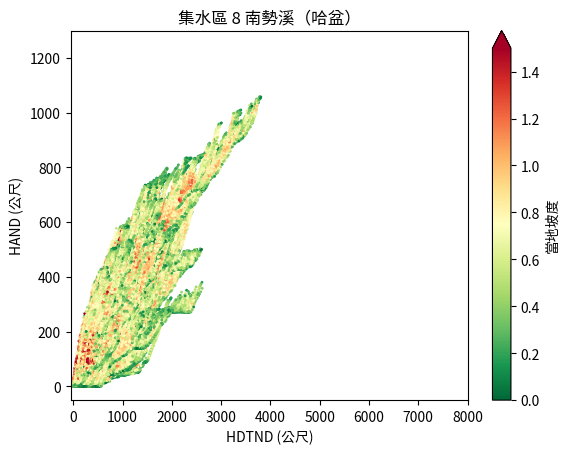

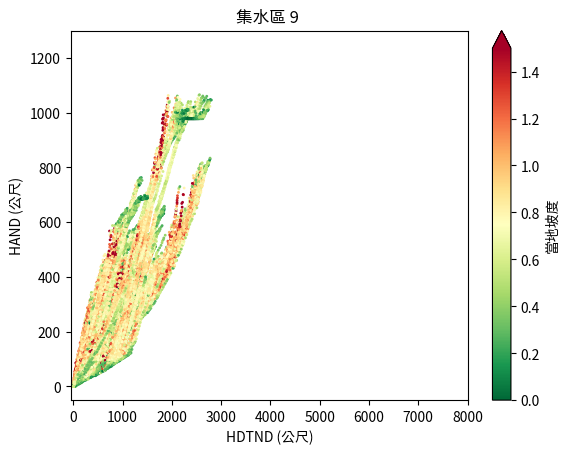

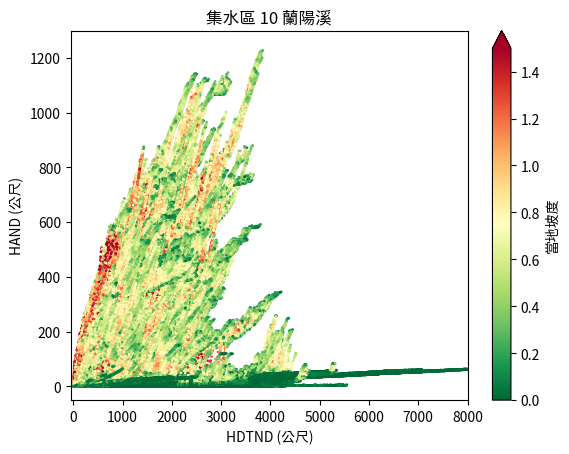

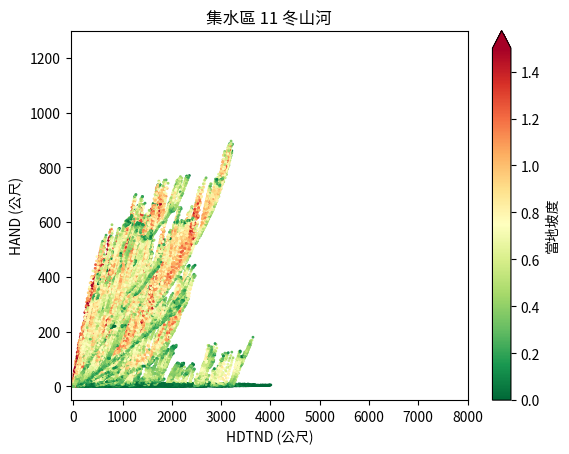

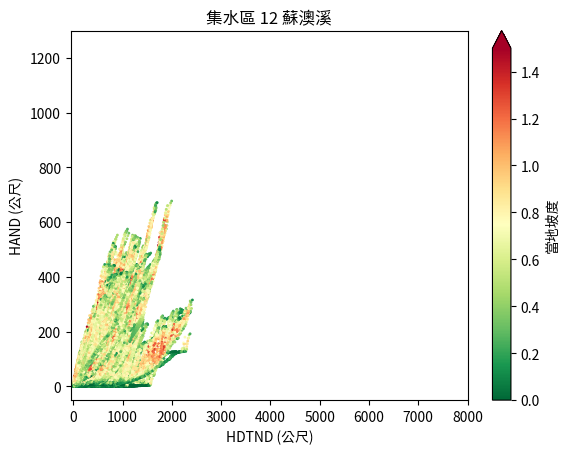

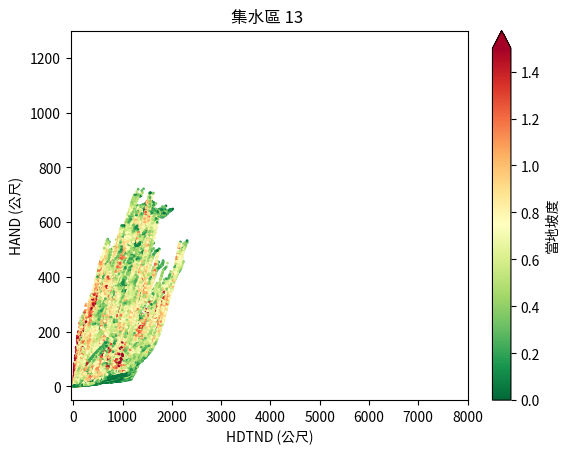

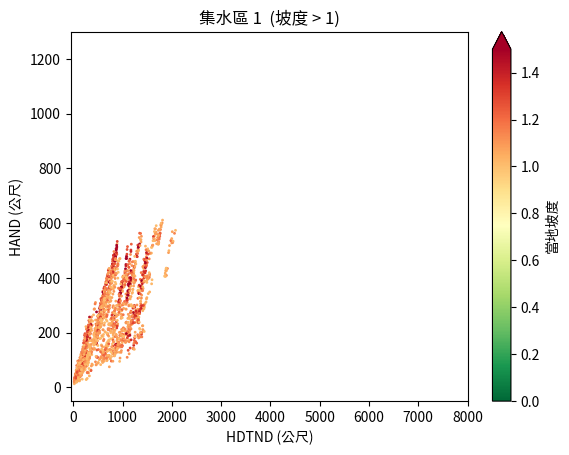

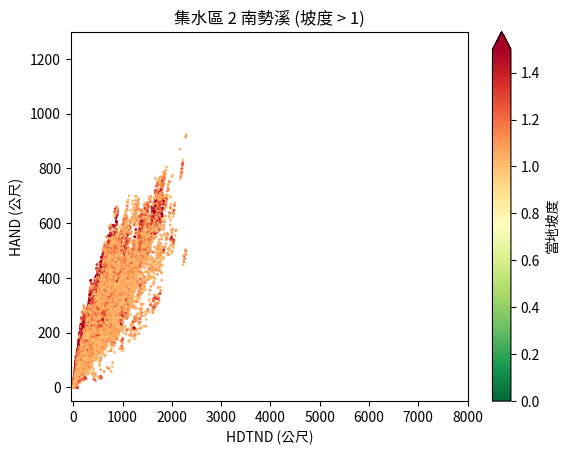

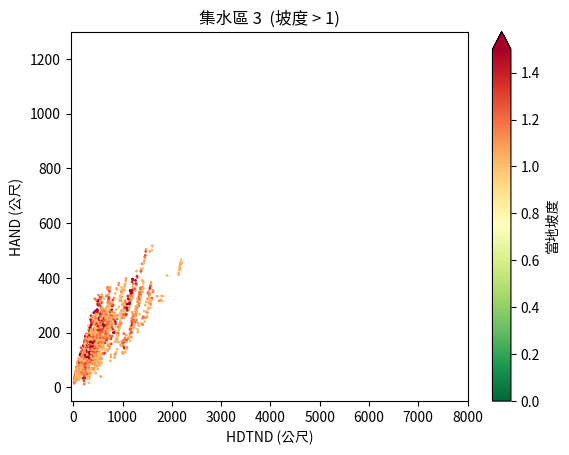

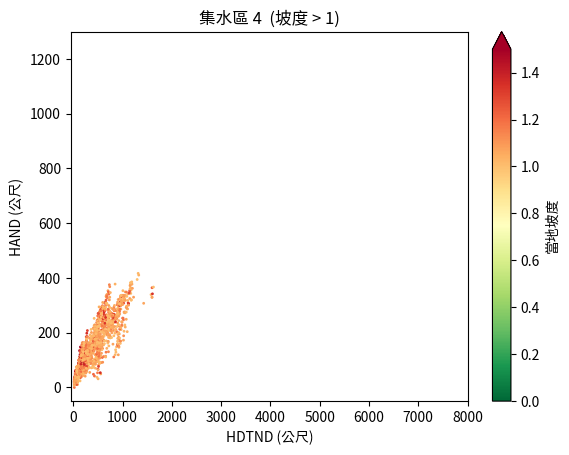

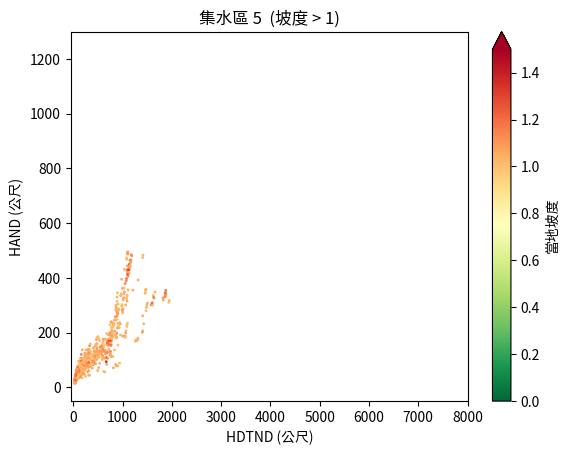

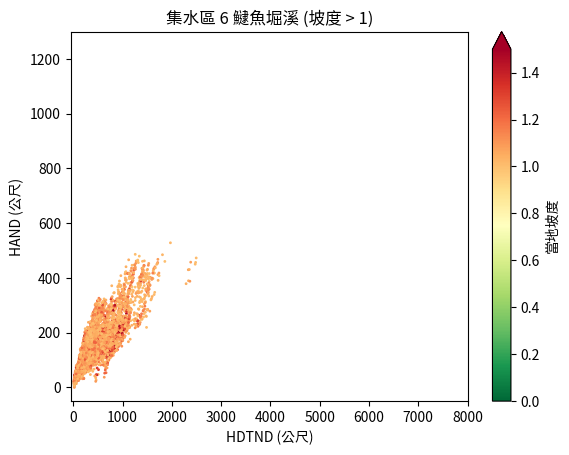

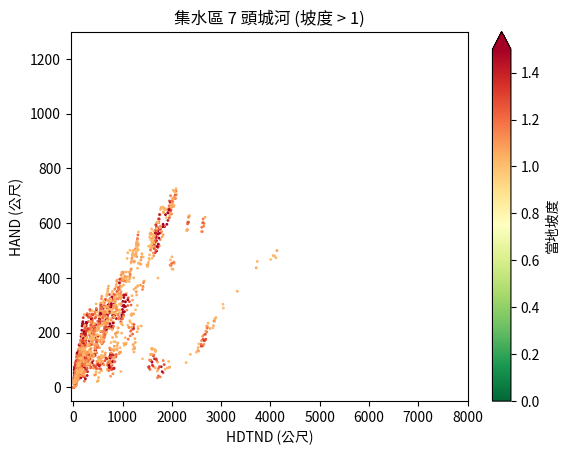

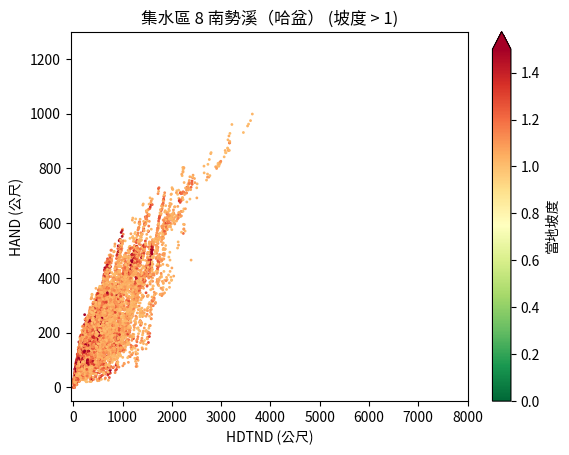

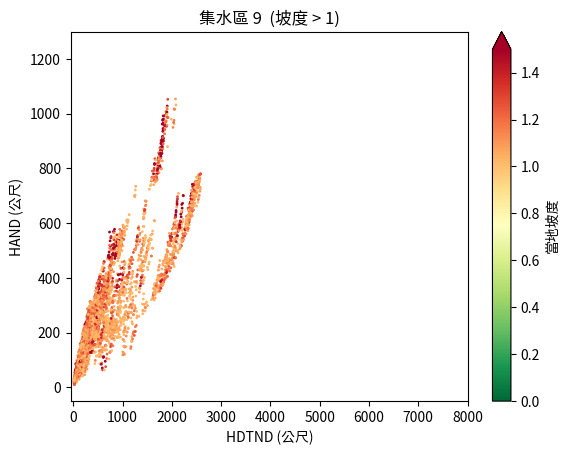

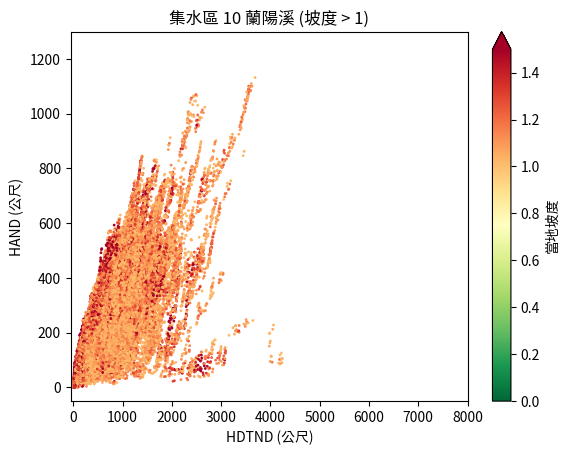

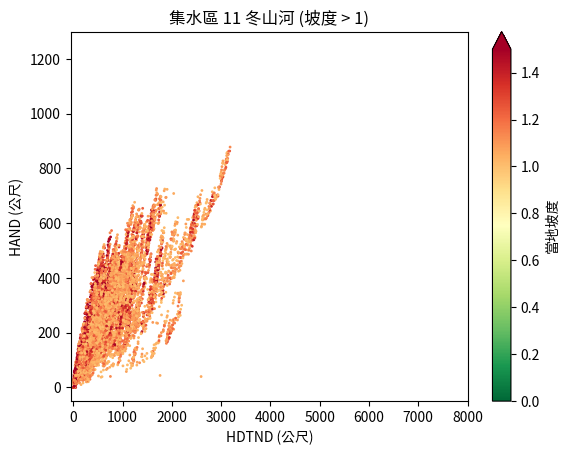

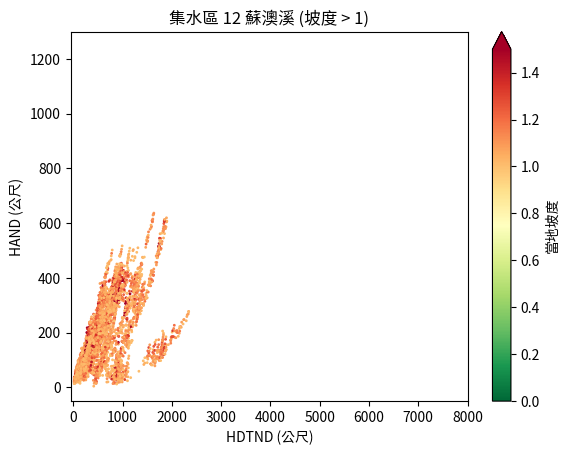

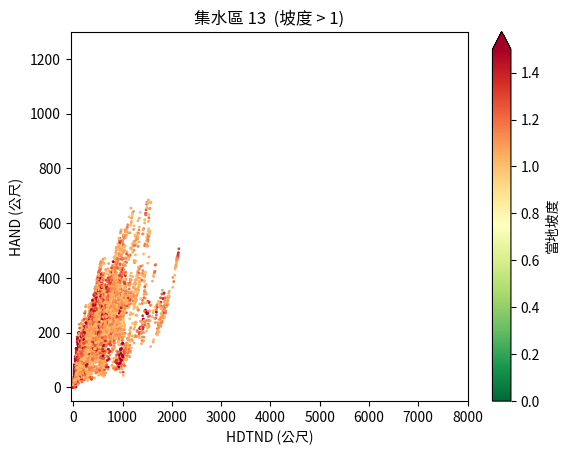

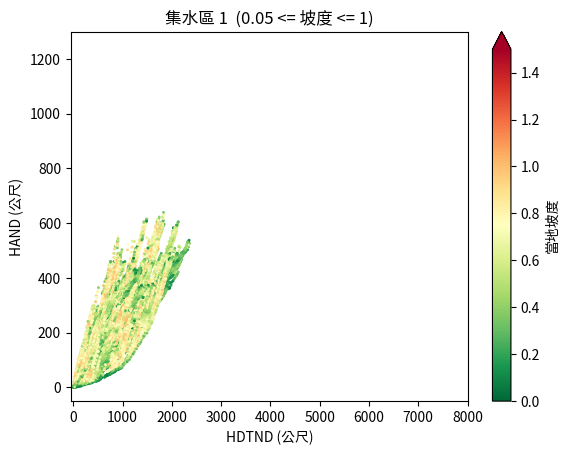

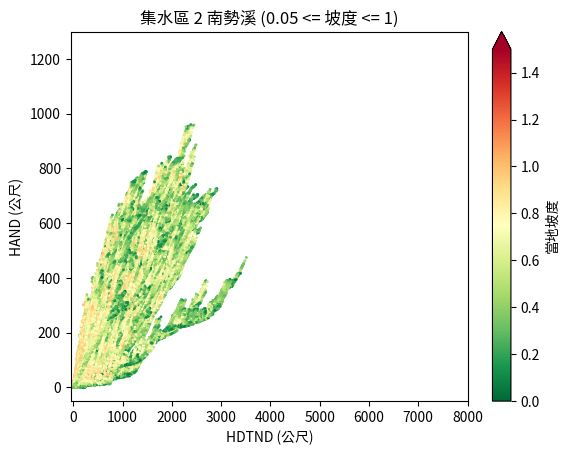

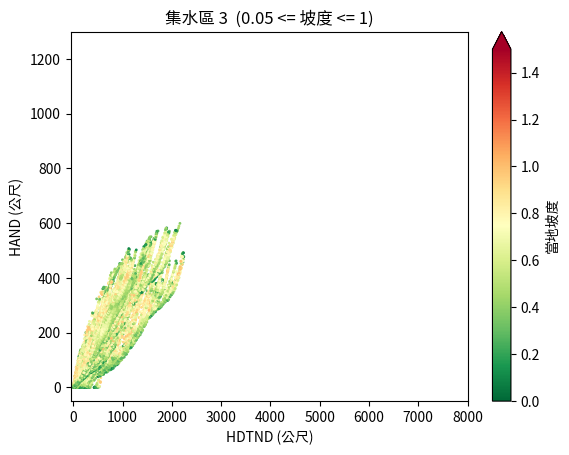

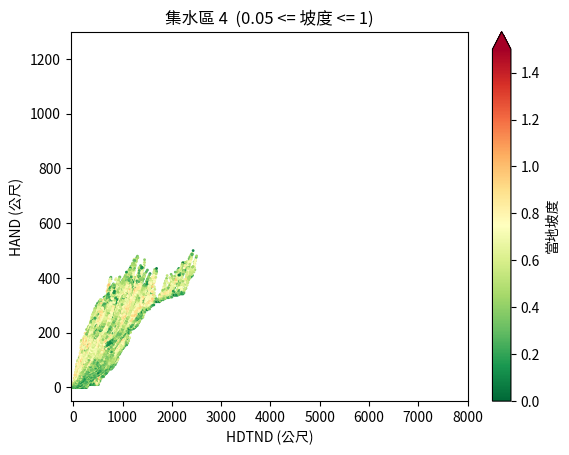

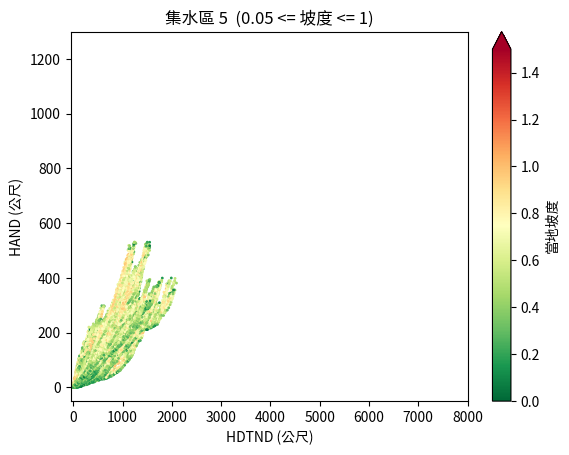

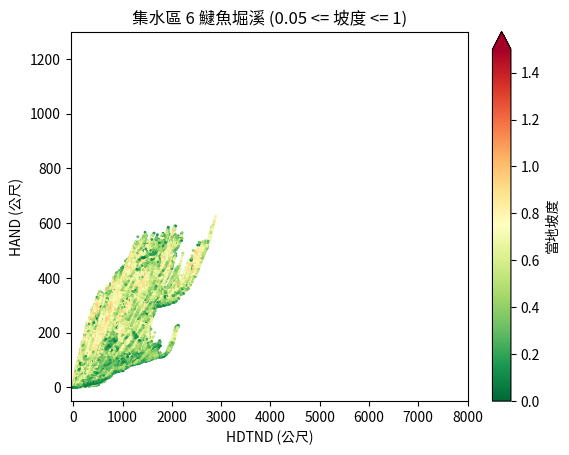

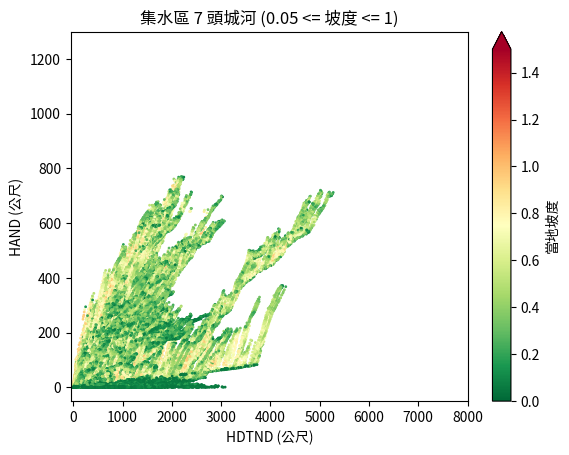

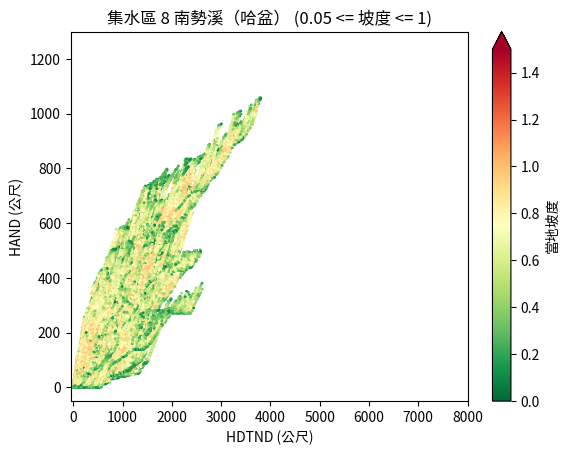

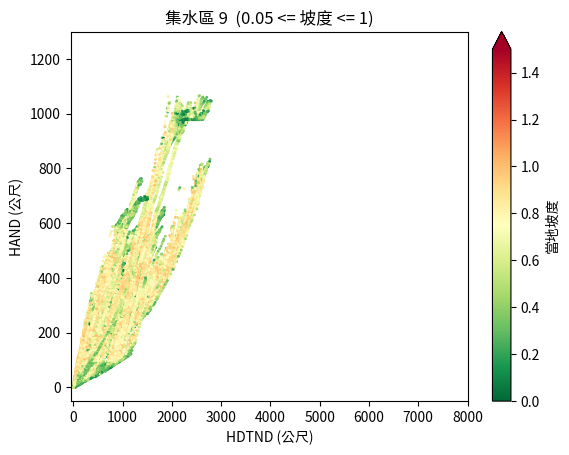

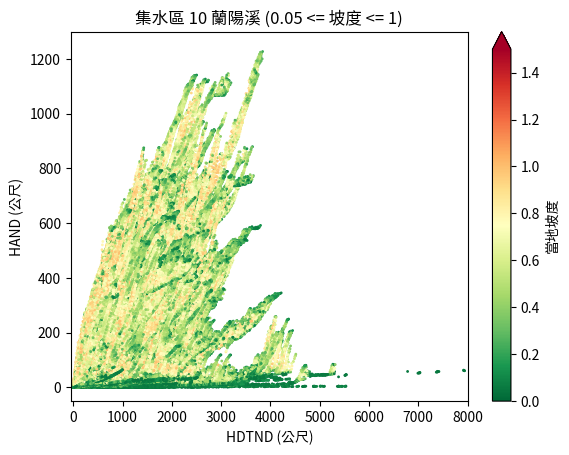

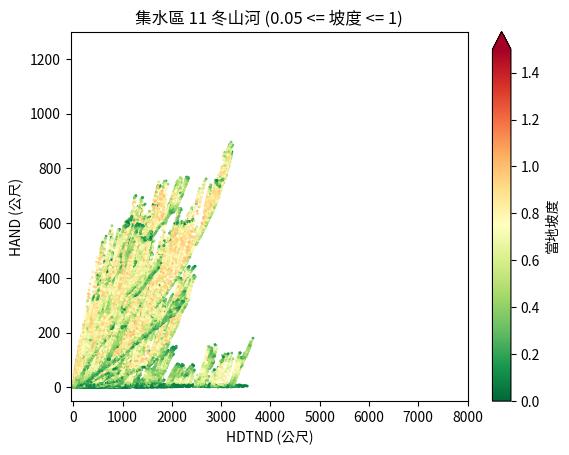

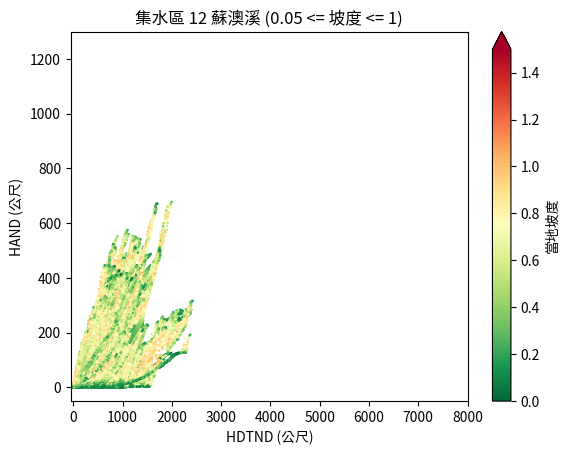

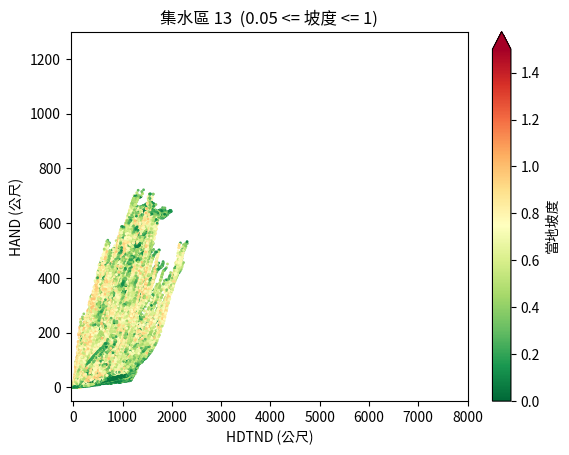

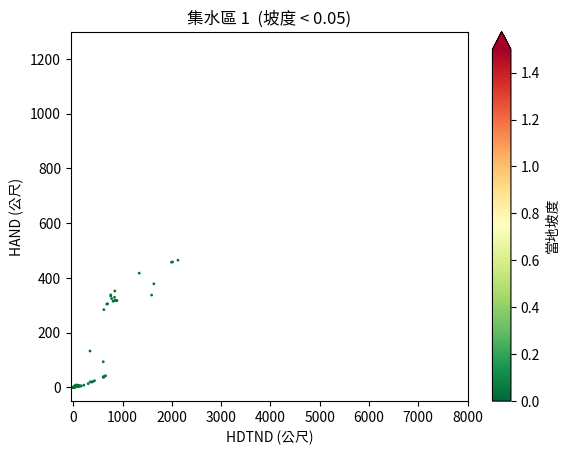

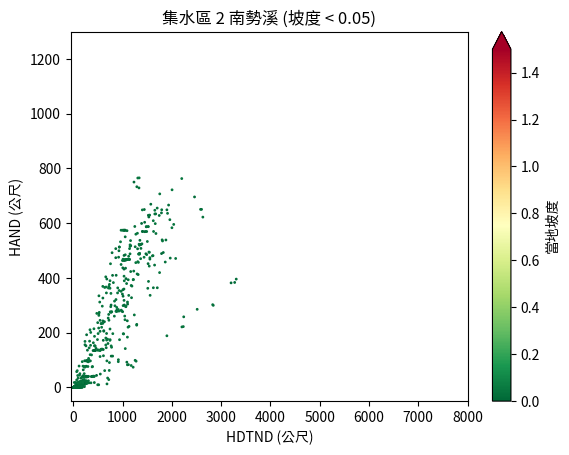

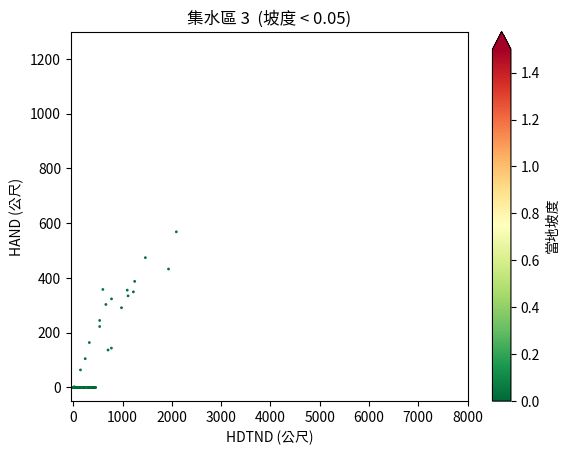

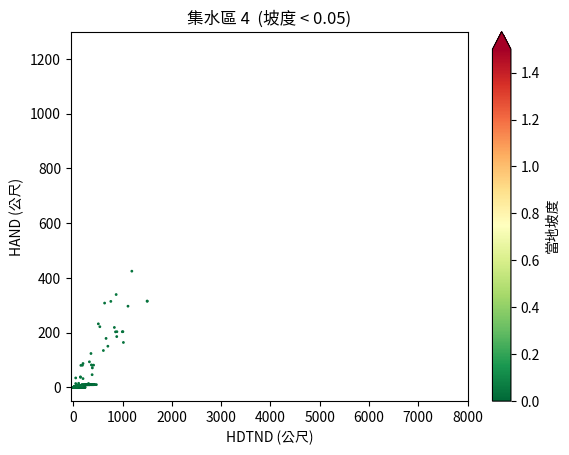

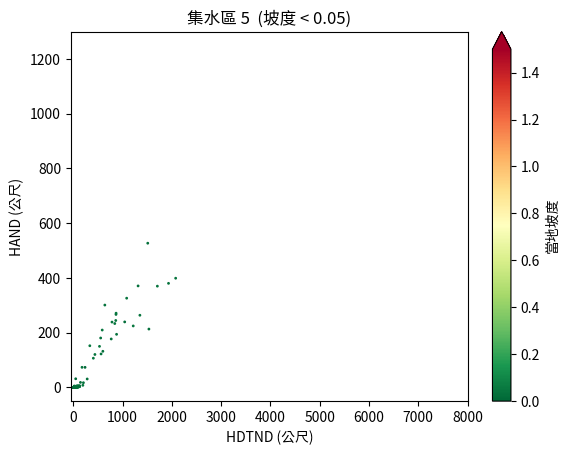

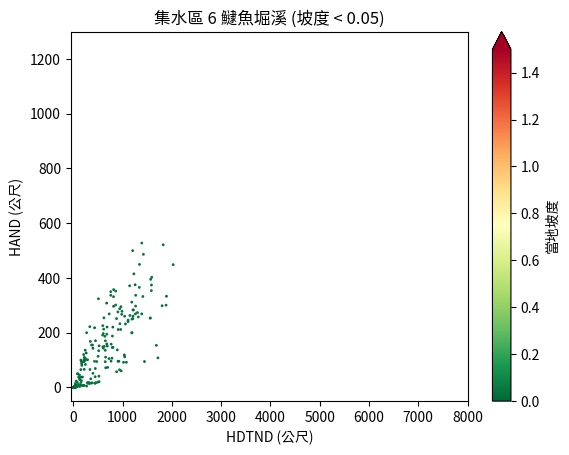

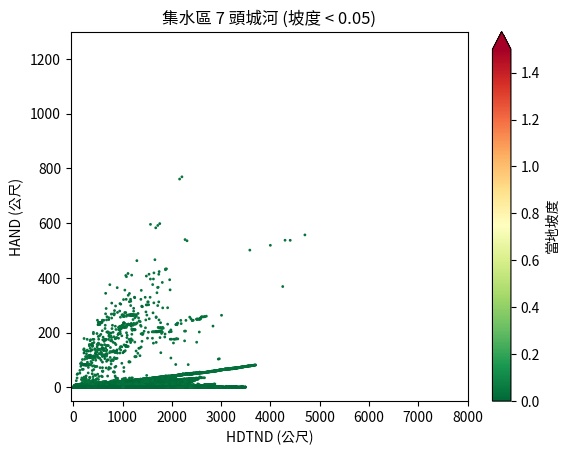

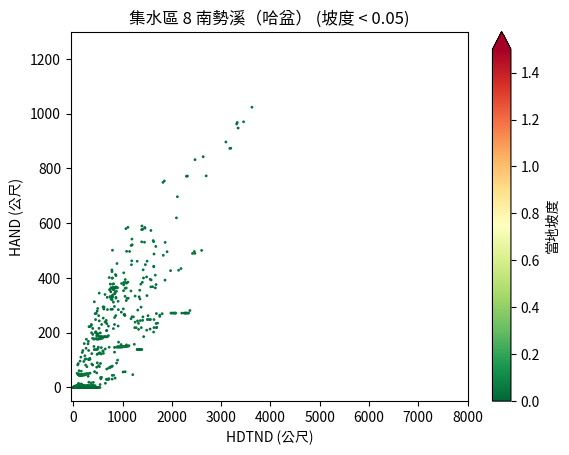

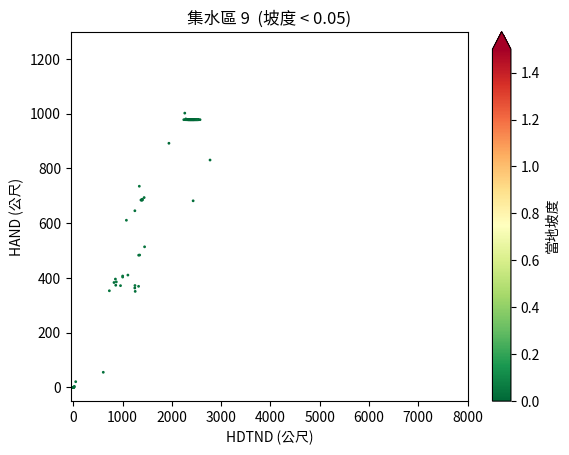

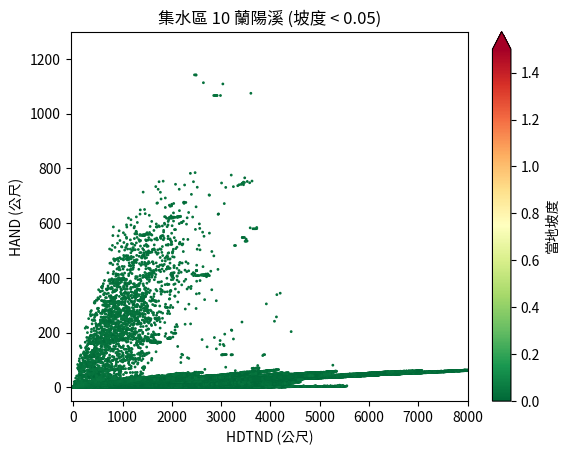

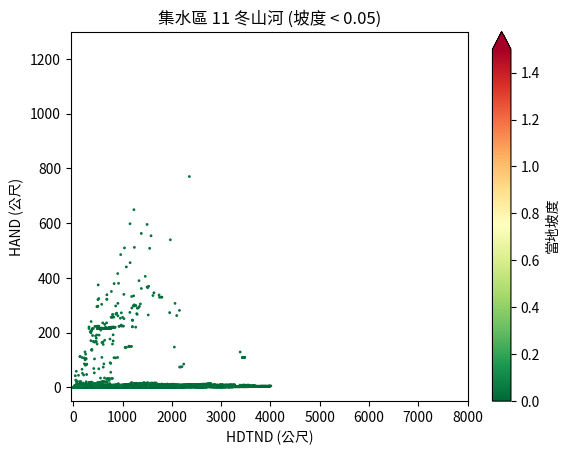

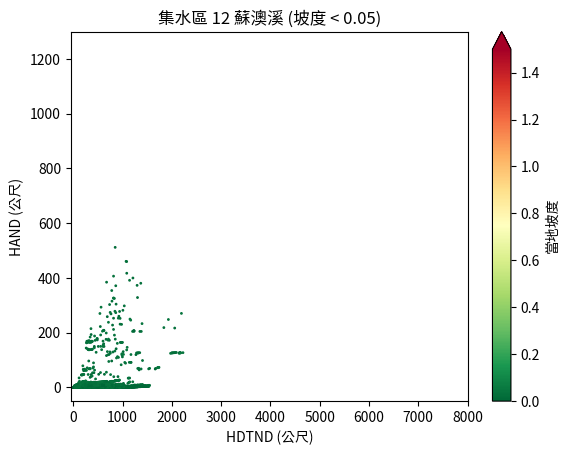

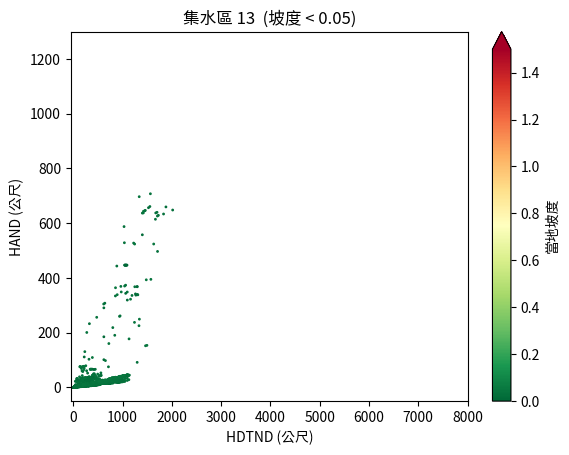

In [107]:
def plot_basin_scatter(mask, description):
    for idx, basin_set in enumerate(basin_masks):
       fig, ax = plt.subplots()
       sc = ax.scatter(d2d_value[basin_set & mask].flatten(),
                       hand_value[basin_set & mask].flatten(),
                       c = slope_value[basin_set & mask].flatten(),
                       s = 1, 
                       cmap = 'RdYlGn_r',
                       vmax = 1.5,
                       vmin = 0)
       cb = fig.colorbar(sc, ax = ax, extend = 'max')
       cb.set_label('當地坡度')
       ax.set(title = f'集水區 {idx + 1} {filtered_ordered_basin_boundaries[idx][1]}{description}',
              xlabel = 'HDTND (公尺)',
              xlim = (-50, 8000),
              ylabel = 'HAND (公尺)',
              ylim = (-50, 1300))
       plt.show()
       plt.close()

plot_basin_scatter((modified_elevation != np.nan), '')
plot_basin_scatter((slope_value > 1), ' (坡度 > 1)')
plot_basin_scatter((slope_value >= 0.05) & (slope_value <= 1), ' (0.05 <= 坡度 <= 1)')
plot_basin_scatter((slope_value < 0.05), ' (坡度 < 0.05)')

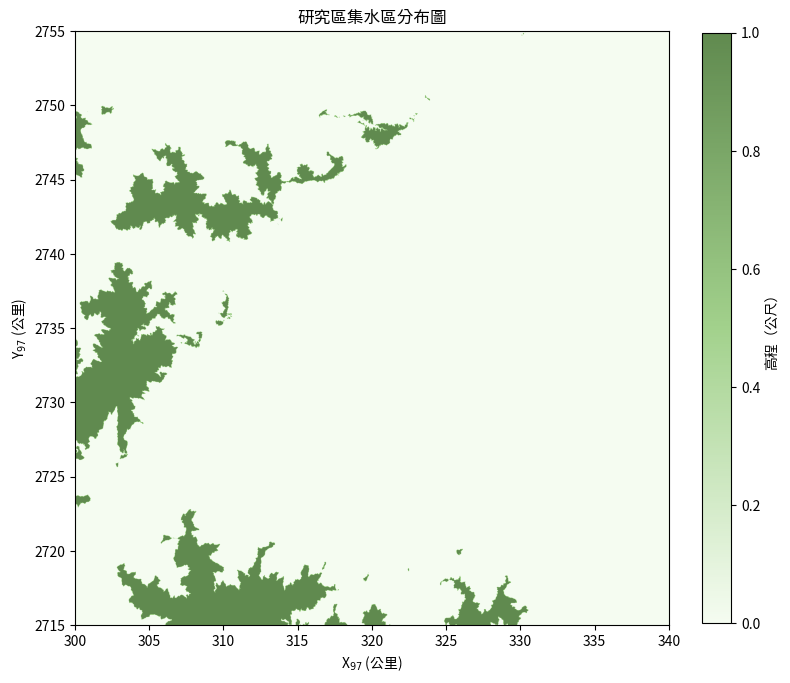

In [95]:
show_terrain_2D(np.where(modified_elevation > 1000, True, False),
                title = '研究區集水區分布圖',
                colorbar_label = '高程（公尺）',
                xlabel = 'X$_{97}$ (公里)',
                ylabel = 'Y$_{97}$ (公里)',
                size = (8, 8),
                extent = source_extent,
                extent_scale = source_scale,
                invert_y_axis = False)

(Bottom cells are abandoned idea)

In [130]:
start_points = [
    {'coord': [327000, 2750600], 'name': '後湖子山 (647m)', 'group': '山地'},
    {'coord': [316100, 2725700], 'name': '大湖桶山 (721m)', 'group': '山地'},
    {'coord': [310900, 2742500], 'name': '阿玉山 (1385m)', 'group': '山地'},
    {'coord': [300900, 2730500], 'name': '棲蘭山 (1899m)', 'group': '山地'},
    {'coord': [311300, 2715800], 'name': '遭難山 (1912m)', 'group': '山地'},
    {'coord': [324887, 2723244], 'name': '中城 (360m)', 'group': '山麓'},
    {'coord': [322950, 2744590], 'name': '佛光大學南側 (387m)', 'group': '山麓'},
    {'coord': [312281, 2733764], 'name': '頂粗坑 (500m)', 'group': '山麓'},
    {'coord': [326700, 2749290], 'name': '礁溪西北側 I (556m)', 'group': '山麓'},
    {'coord': [326770, 2749290], 'name': '礁溪西北側 II (630m)', 'group': '山麓'},
    {'coord': [326700, 2738900], 'name': '宜蘭站 (6m)', 'group': '平原'},
    {'coord': [329800, 2747000], 'name': '頭城交流道 (6m)', 'group': '平原'},
    {'coord': [328400, 2730300], 'name': '羅東站 (7m)', 'group': '平原'},
    {'coord': [315810, 2730950], 'name': '三星 (90m)', 'group': '平原'},
    {'coord': [300200, 2719200], 'name': '土場 (154m)', 'group': '平原'}
]
start_points_scaled = np.array([point['coord'] for point in start_points]).T * source_scale
groups = ['山地', '山麓', '平原']

# Retrieve flow paths
path_index, _distance = flow_direction.path(
    xy = start_points_scaled / source_scale,
    mask = flow_direction.stream_order() >= 6,
    max_length = 1e6,
    unit = 'm'
)

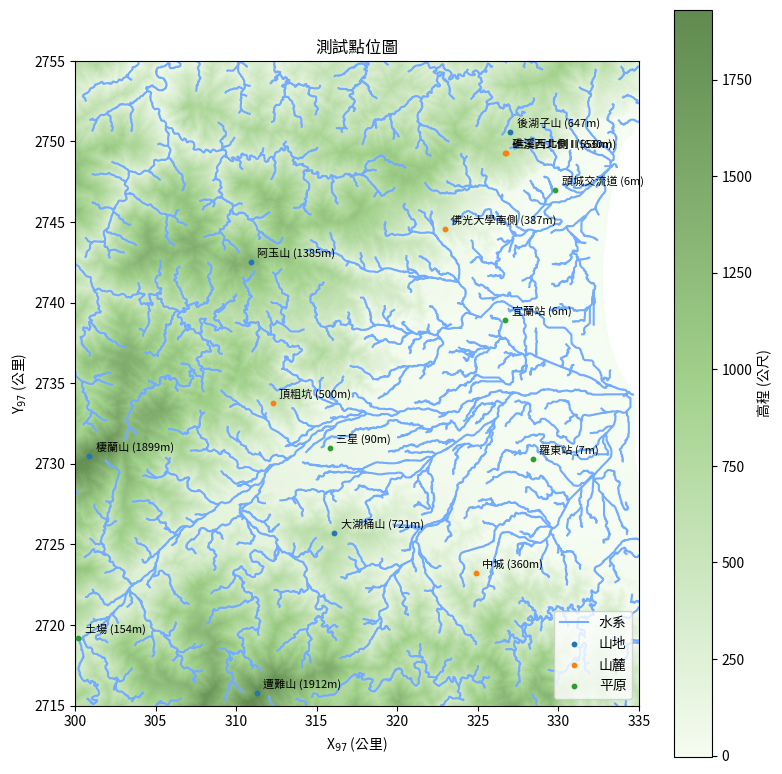

In [133]:
cmap = matplotlib.colormaps['tab10']
cm_colors = [cmap(i) for i in range(cmap.N)]

show_terrain_2D(modified_elevation,
                title = '測試點位圖',
                colorbar_label = '高程 (公尺)',
                xlabel = 'X$_{97}$ (公里)',
                ylabel = 'Y$_{97}$ (公里)',
                size = (8, 8),
                equal_scale = True,
                extent = source_extent,
                extent_scale = source_scale,
                invert_y_axis = False,
                cont = True)

for idx, stream in enumerate(streams_coordinates):
    plt.gca().plot(stream[0], stream[1], color = '#73ACFF', label = '水系' if idx == 0 else None)
for g_index, group in enumerate(groups):
    plotted = False
    for idx, point in enumerate(start_points_scaled.T):
        if (start_points[idx]['group'] == group):
            plt.gca().scatter(point[0],
                              point[1],
                              s = 10,
                              color = cm_colors[g_index],
                              zorder = 3,
                              label = group if not plotted else None)
            plt.gca().text(point[0] + 0.4, point[1] + 0.2,
                           start_points[idx]['name'],
                           fontsize = 8,
                           ha = 'left',
                           va = 'bottom')
            plotted = True
plt.gca().legend(loc = 4)
plt.show()

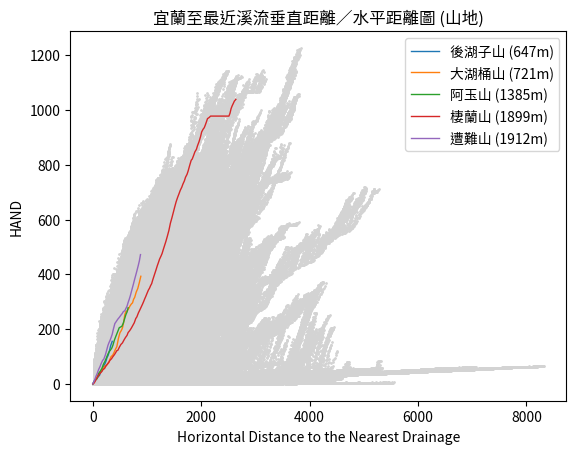

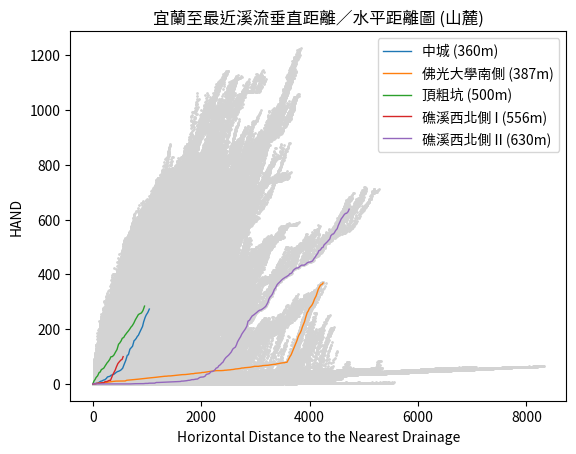

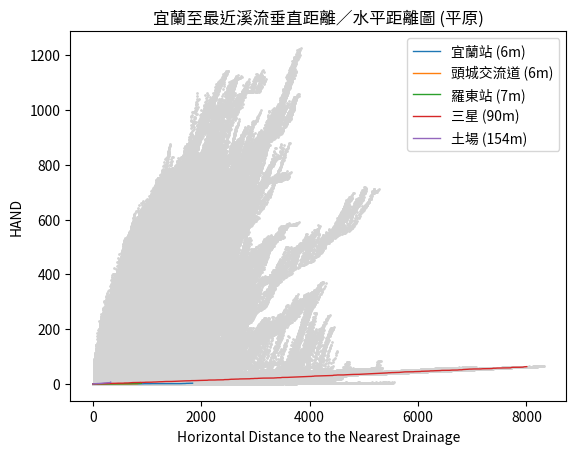

In [134]:
for group in groups:
    fig, ax = plt.subplots()
    ax.scatter(d2d_value.flatten(), hand_value.flatten(), s = 1, c = 'lightgrey') 
    ax.set(xlabel = 'Horizontal Distance to the Nearest Drainage', ylabel = 'HAND')
    for idx, path in enumerate(path_index):
        if (start_points[idx]['group'] == group):
            ax.plot(d2d_value.flatten()[path],
                    hand_value.flatten()[path],
                    linewidth = 1,
                    zorder = 5,
                    label = start_points[idx]['name'])
    ax.set_title(f'宜蘭至最近溪流垂直距離／水平距離圖 ({group})')
    ax.legend(loc = 1)
    plt.show()

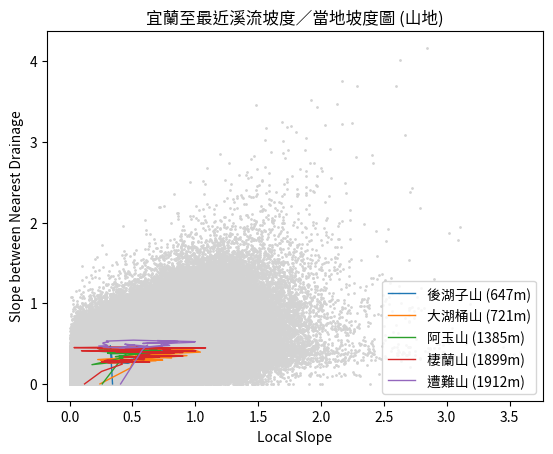

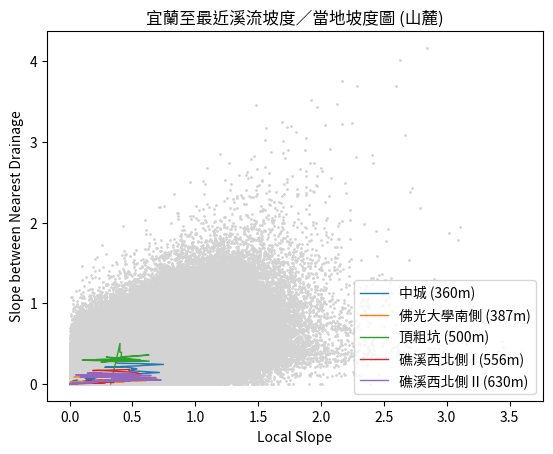

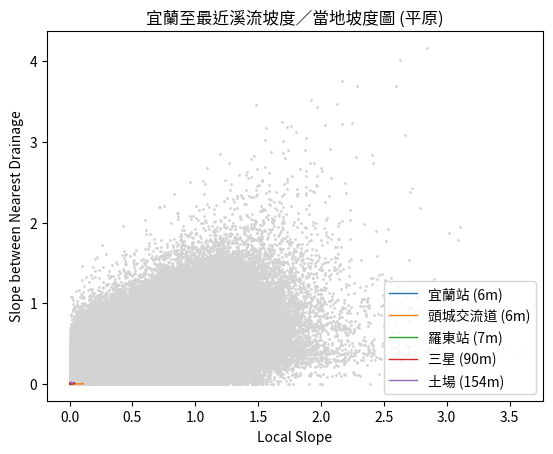

In [135]:
for group in groups:
    fig, ax = plt.subplots()
    ax.scatter(slope_value.flatten(), sbnd_value.flatten(), s = 1, c = 'lightgrey') 
    ax.set(xlabel = 'Local Slope', ylabel = 'Slope between Nearest Drainage')
    for idx, path in enumerate(path_index):
        if (start_points[idx]['group'] == group):
            ax.plot(slope_value.flatten()[path],
                    sbnd_value.flatten()[path],
                    linewidth = 1,
                    zorder = 5,
                    label = start_points[idx]['name'])
    ax.set_title(f'宜蘭至最近溪流坡度／當地坡度圖 ({group})')
    ax.legend(loc = 4)
    plt.show()

## Combining all together

### Thresholds

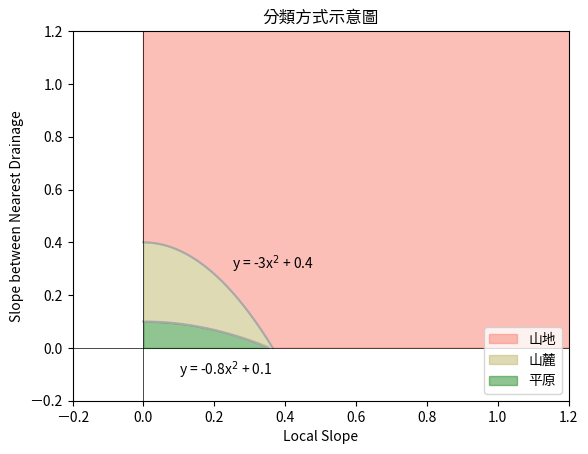

In [136]:
def f(x):
    return -3 * x ** 2 + 0.4

def g(x):
    return -0.8 * x ** 2 + 0.1

# Generate x values
x = np.linspace(0, np.sqrt(0.4 / 3), 500)  # x for f(x) is limited to where f(x) >= 0
x2 = np.linspace(0, np.sqrt(0.1 / 0.8), 500)  # x for g(x) is limited to where g(x) >= 0

# Calculate y values
y_f = f(x)
y_f_cont = f(np.linspace(0, 4, 2000))
y_f_cont[y_f_cont < 0] = 0
y_g = g(x2)

# Create the plot
fig, ax = plt.subplots()

# Fill areas
ax.fill_between(np.linspace(0, 4, 2000), y_f_cont, np.full(2000, 4), color = 'salmon', alpha = 0.5, label = '山地')
ax.fill_between(x, y_f, y_g[:len(x)], where=(y_f >= y_g[:len(x)]),   color = 'darkkhaki',   alpha = 0.5, label = '山麓')
ax.fill_between(x2, y_g, where = (y_g >= 0),                         color = 'forestgreen', alpha = 0.5, label = '平原')

# Plot the functions
ax.plot(x, y_f, color='darkgrey')
ax.plot(x2, y_g, color='darkgrey')
ax.text(0.25, 0.3, 'y = -3x$^2$ + 0.4')
ax.text(0.1, -0.1, 'y = -0.8x$^2$ + 0.1')

# Axes labels and legend
ax.set_title('分類方式示意圖')
ax.set_xlabel('Local Slope')
ax.set_ylabel('Slope between Nearest Drainage')
ax.set_xlim(-0.2, 1.2)
ax.set_ylim(-0.2, 1.2)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.legend(loc = 4)

# Show plot
plt.show()

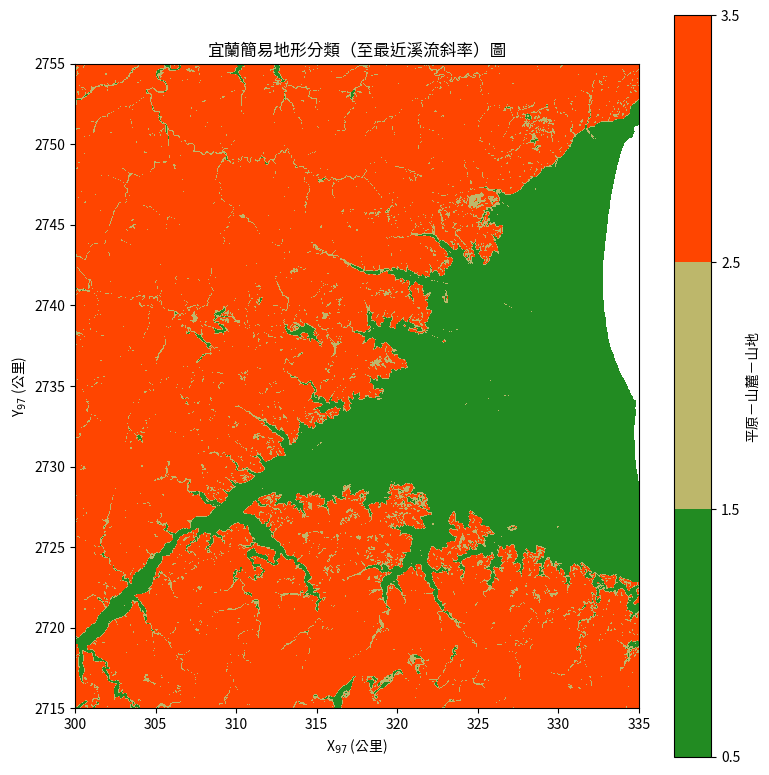

In [137]:
sbnd_high = np.where(sbnd_value.flatten() > (-3 * slope_value.flatten() ** 2 + 0.4), 3, 0)
sbnd_mid  = np.where((sbnd_value.flatten() > (-0.8 * slope_value.flatten() ** 2 + 0.1)) & (sbnd_value.flatten() <= (-3 * slope_value.flatten() ** 2 + 0.4)), 2, 0)
sbnd_low  = np.where((sbnd_value.flatten() <= (-0.8 * slope_value.flatten() ** 2 + 0.1)), 1, 0)
sbnds     = np.where(modified_elevation > -32657, (sbnd_high + sbnd_mid + sbnd_low).reshape(source_elevation.shape), np.nan)

bound_cmap = colors.ListedColormap(['forestgreen', 'darkkhaki', 'orangered'])
bound_norm = colors.BoundaryNorm(boundaries = [0.5, 1.5, 2.5, 3.5], ncolors = 3)

show_terrain_2D(sbnds,
                cmap = bound_cmap,
                title = '宜蘭簡易地形分類（至最近溪流斜率）圖',
                colorbar_label = '平原－山麓－山地',
                xlabel = 'X$_{97}$ (公里)',
                ylabel = 'Y$_{97}$ (公里)',
                size = (8, 8),
                equal_scale = True,
                extent = source_extent,
                extent_scale = source_scale,
                invert_y_axis = False,
                norm = bound_norm)

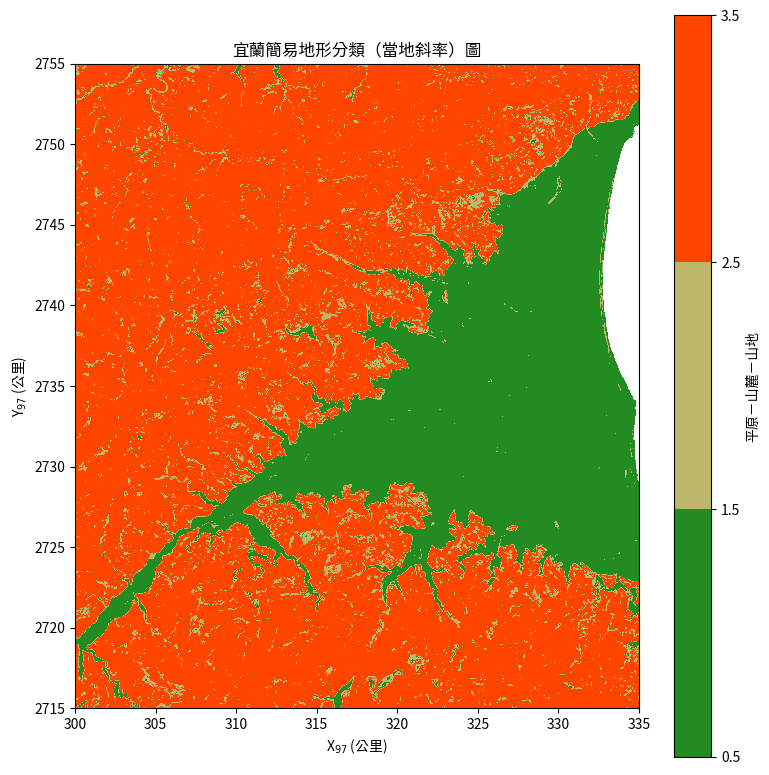

In [138]:
slope_high = np.where((slope_value.flatten() > 0.3), 3, 0)
slope_mid  = np.where((slope_value.flatten() > 0.1) & (slope_value.flatten() <= 0.3), 2, 0)
slope_low  = np.where((slope_value.flatten() <= 0.1), 1, 0)
slopes     = np.where(modified_elevation > -32657, (slope_high + slope_mid + slope_low).reshape(source_elevation.shape), np.nan)

show_terrain_2D(slopes,
                cmap = bound_cmap,
                title = '宜蘭簡易地形分類（當地斜率）圖',
                colorbar_label = '平原－山麓－山地',
                xlabel = 'X$_{97}$ (公里)',
                ylabel = 'Y$_{97}$ (公里)',
                size = (8, 8),
                equal_scale = True,
                extent = source_extent,
                extent_scale = source_scale,
                invert_y_axis = False,
                norm = bound_norm)